##Activación

Activar sincronizacion con Google Drive

In [241]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nos movemos al directorio que contiene el proyecto

In [242]:
%cd /content/drive/My Drive/Proyecto-Inteligencia/03-Prototipo
!pwd

/content/drive/My Drive/Proyecto-Inteligencia/03-Prototipo
/content/drive/My Drive/Proyecto-Inteligencia/03-Prototipo


##Importacion

Importamos librerias necesarias para la ejecución del proyecto 

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA

Mostramos la información del dataset que vamos a tratar:

In [244]:
inf = pd.read_csv('../data/csv/Descripcion_campos.csv')
print(inf)

    Orden  ...                                        Descripcion
0       1  ...           0 Código de la estación de meteorológica
1       2  ...              1 Fecha de los datos de este registro
2       3  ...                          2 Temperatura máxima (ºC)
3       4  ...                           3 Temperatura media (ºC)
4       5  ...                          4 Temperatura mínima (ºC)
5       6  ...                      5 Humedad relativa máxima (%)
6       7  ...                       6 Humedad relativa media (%)
7       8  ...                      7 Humedad relativa mínima (%)
8       9  ...                        8 Radicación media (w*h/m2)
9      10  ...                                9 Lluvia total (mm)
10     11  ...               14 Velocidad de viento máxima (Km/h)
11     12  ...                15 Velocidad de viento media (Km/h)
12     13  ...               16 Velocidad de viento mínima (Km/h)
13     14  ...  17 Minutos con dirección de viento en el prime...
14     15 

Importamos dataset

In [245]:
df = pd.read_csv('../data/csv/rain2019.csv')
df.info() #Despliega la informacion del dataset
df.head() #Despliega la cabecera del dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13396 entries, 0 to 13395
Data columns (total 18 columns):
cod_est                13396 non-null object
FECHA                  13396 non-null object
T_Max                  13382 non-null float64
T_Med                  13382 non-null float64
T_Min                  13382 non-null float64
H_R_Max                13385 non-null float64
H_R_Med                13385 non-null float64
H_R_Min                13385 non-null float64
PromedioDeRadiacion    13388 non-null float64
SumaDeLluvia           13345 non-null float64
V_Max                  12850 non-null float64
V_Med                  12850 non-null float64
V_Min                  12657 non-null float64
SumaDeCV1              13386 non-null float64
SumaDeCV2              13386 non-null float64
SumaDeCV3              13386 non-null float64
SumaDeCV4              13386 non-null float64
PromedioDeDireccion    13396 non-null float64
dtypes: float64(16), object(2)
memory usage: 1.8+ MB


,cod_est,FECHA,T_Max,T_Med,T_Min,H_R_Max,H_R_Med,H_R_Min,PromedioDeRadiacion,SumaDeLluvia,V_Max,V_Med,V_Min,SumaDeCV1,SumaDeCV2,SumaDeCV3,SumaDeCV4,PromedioDeDireccion
0,AL001,2019-01-01T00:00:00,18.03,8.880042,2.370,94.9,69.756667,29.35,0.399086,0.0,16.20,3.021750,0.0,389.0,509.0,542.0,0.0,2.166667
1,AL001,2019-01-02T00:00:00,15.94,8.196292,1.488,96.2,83.562500,65.16,0.389498,0.0,18.00,3.448000,0.0,129.0,861.0,438.0,9.0,2.291667
2,AL001,2019-01-03T00:00:00,16.55,10.837417,6.040,92.7,74.906667,55.78,0.336150,0.0,20.70,6.000250,0.0,812.0,628.0,0.0,0.0,1.375000
3,AL001,2019-01-04T00:00:00,16.65,8.234125,3.135,95.4,81.607500,51.56,0.376608,0.0,11.70,1.950750,0.0,861.0,481.0,95.0,2.0,1.458333
4,AL001,2019-01-05T00:00:00,15.23,7.447917,1.825,93.1,80.821667,51.06,0.403922,0.0,17.55,3.652042,0.0,829.0,87.0,516.0,7.0,1.791667


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f23c77edb00>,
      dtype=object)

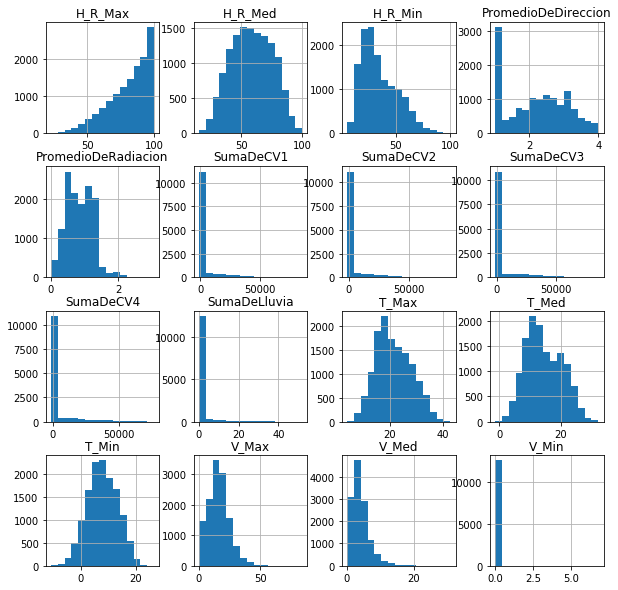

In [246]:
df.hist(bins=15, figsize=(10,10))

##Preprocesamiento de datos

Eliminamos las columnas que no nos son de utilidad para limpiar el dataset y reindexamos por fecha

In [247]:
print(type(df))
del df['cod_est']
del df['V_Min']
del df['SumaDeLluvia']
del df['SumaDeCV1']
del df['SumaDeCV2']
del df['SumaDeCV3']
del df['SumaDeCV4']
df['FECHA'] = pd.to_datetime(df['FECHA']) #Se convierte la fecha a formato de tiempo
df.set_index('FECHA', inplace=True) #Utilizamos la fecha como indice
df.dropna(inplace = True) #Elimina campos vacios
df.head()

<class 'pandas.core.frame.DataFrame'>


,T_Max,T_Med,T_Min,H_R_Max,H_R_Med,H_R_Min,PromedioDeRadiacion,V_Max,V_Med,PromedioDeDireccion
FECHA,,,,,,,,,,
2019-01-01,18.03,8.880042,2.370,94.9,69.756667,29.35,0.399086,16.20,3.021750,2.166667
2019-01-02,15.94,8.196292,1.488,96.2,83.562500,65.16,0.389498,18.00,3.448000,2.291667
2019-01-03,16.55,10.837417,6.040,92.7,74.906667,55.78,0.336150,20.70,6.000250,1.375000
2019-01-04,16.65,8.234125,3.135,95.4,81.607500,51.56,0.376608,11.70,1.950750,1.458333
2019-01-05,15.23,7.447917,1.825,93.1,80.821667,51.06,0.403922,17.55,3.652042,1.791667


##Despliegue grafico

Hacemos el histograma de cada columna

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f23504010b8>,
      dtype=object)

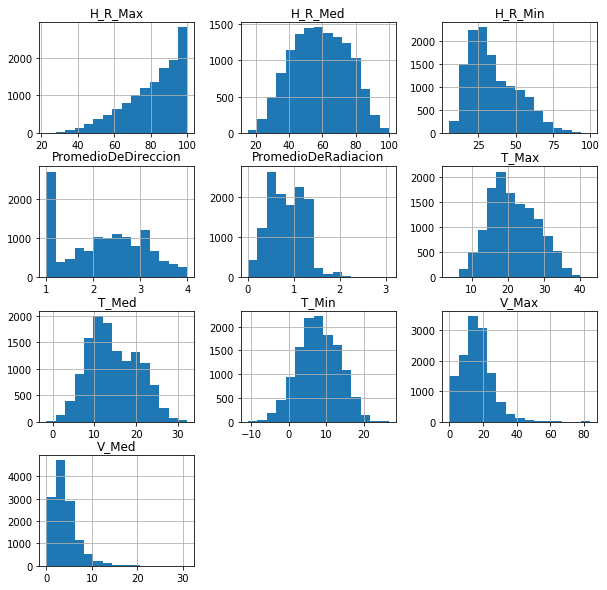

In [248]:
df.hist(bins=15, figsize=(10,10))

Miramos la correlación que tienen las columnas del dataset

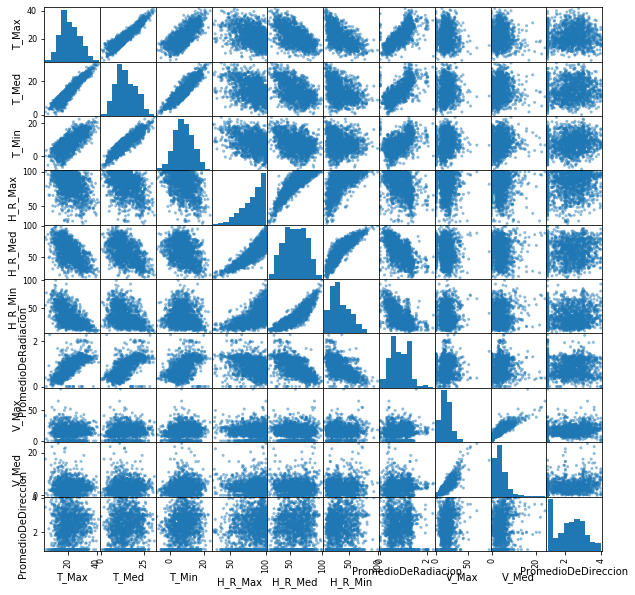

In [249]:
pd.plotting.scatter_matrix(df.sample(1500), figsize=(10,10));

#Procesamiento de datos

Pasamos el dataframe a un arreglo Numpy, lo permutamos para asegurarnos de tomar muestras aleatorias y definimos nuestras características (X) y etiquetas (y).

In [250]:
val = np.random.permutation(df.values)
X = val[:,[0,1,2,3,4,5,6,8,9]]
y = val[:,6]
print(X.shape)
print(type(X))
print(y.shape)
print(type(y))


(12827, 9)
<class 'numpy.ndarray'>
(12827,)
<class 'numpy.ndarray'>


Miramos cuales son los valores maximos y minimos de cada columna.

In [251]:
maximo = df.max(axis = 0 )
minimo = df.min(axis = 0)
print('Maximos de cada columna:\n',maximo)
print('\nMinimos de cada columna:\n',minimo)

Maximos de cada columna:
 T_Max                   42.800000
T_Med                   32.272083
T_Min                   26.700000
H_R_Max                100.000000
H_R_Med                100.000000
H_R_Min                100.000000
PromedioDeRadiacion      3.066300
V_Max                   83.900000
V_Med                   31.042083
PromedioDeDireccion      4.000000
dtype: float64

Minimos de cada columna:
 T_Max                   3.869000
T_Med                  -1.463458
T_Min                 -10.850000
H_R_Max                22.910000
H_R_Med                15.410417
H_R_Min                 5.636000
PromedioDeRadiacion     0.000000
V_Max                   0.000000
V_Med                   0.000000
PromedioDeDireccion     1.000000
dtype: float64


**PCA**

In [0]:
X = PCA(n_components=4).fit_transform(X)

Definimos nuestros valores para entrenamiento y prueba, y el tamaño de cada uno

In [253]:
X = X.astype('float32')#Lo pasamos a flotantes
y = y.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8978, 9) (8978,) (3849, 9) (3849,)


#Machine Learning

## 1. Random Forest:


Definir un objeto de tipo RandomForestRegressor

In [254]:
#Se aplica Random Forest
est_RF= RandomForestRegressor()
s = cross_val_score(est_RF, X, y, cv=KFold(20, shuffle=True), scoring=make_scorer(mean_squared_error))
print ("MSE %.6f (+/- %.5f)"%(np.mean(s), np.std(s)))

MSE 0.000025 (+/- 0.00008)


Entrenamos nuestro modelo, y hacemos las predicciones

In [0]:
est_RF.fit(X_train, y_train)
predic_RF = est_RF.predict(X_test)

Graficamos las predicciones con el test, para saber el nivel de precisión de nuestro modelo.

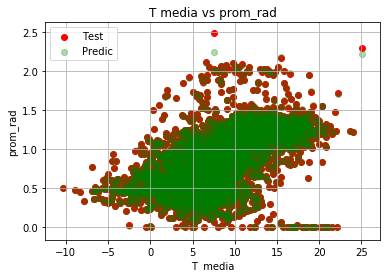

In [256]:
plt.scatter(X_test[:,2], y_test, color = "red")
plt.scatter(X_test[:,2], predic_RF, color = "green", alpha = .3)
plt.grid()
plt.legend(labels=['Test','Predic'])
plt.title("T media vs prom_rad")
plt.xlabel("T  media")
plt.ylabel("prom_rad")
plt.show()

## 2. Decision tree:

Definir un objeto de tipo DecisionTreeRegressor

In [257]:
#Se aplica decision tree
est_DT = DecisionTreeRegressor()
s = cross_val_score(est_DT, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(mean_squared_error))
print("MSE %.6f (+/- %.5f)"%(np.mean(s), np.std(s)))

MSE 0.000049 (+/- 0.00009)


Entrenamos nuestro modelo, y hacemos las predicciones

In [0]:
est_DT.fit(X_train, y_train)
predic_DT = est_DT.predict(X_test)

Graficamos las predicciones con el test, para saber el nivel de precisión de nuestro modelo.

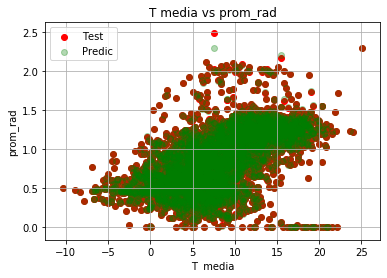

In [259]:
plt.scatter(X_test[:,2], y_test, color = "red")
plt.scatter(X_test[:,2], predic_DT, color = "green", alpha = .3)
plt.grid()
plt.legend(labels=['Test','Predic'])
plt.title("T media vs prom_rad")
plt.xlabel("T  media")
plt.ylabel("prom_rad")
plt.show()

## 3. SVM

Definir un objeto de tipo SVM

In [260]:
#Se aplica SVR
est_SV = SVR()
s = cross_val_score(est_SV, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(mean_squared_error))
print("MSE %.6f (+/- %.5f)"%(np.mean(s), np.std(s)))

MSE 0.024975 (+/- 0.00295)


Entrenamos nuestro modelo, y hacemos las predicciones

In [0]:
est_SV.fit(X_train, y_train)
predic_SV = est_SV.predict(X_test)

Graficamos las predicciones con el test, para saber el nivel de precisión de nuestro modelo.

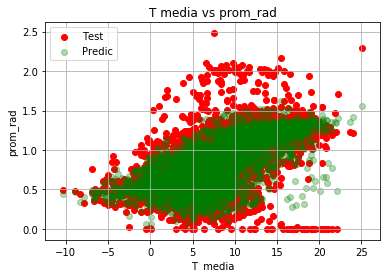

In [262]:
plt.scatter(X_test[:,2], y_test, color = "red")
plt.scatter(X_test[:,2], predic_SV, color = "green", alpha = .3)
plt.title("T media vs prom_rad")
plt.grid()
plt.legend(labels=['Test','Predic'])
plt.xlabel("T  media")
plt.ylabel("prom_rad")
plt.show()

# 4. Deep learning:

In [0]:
model = keras.models.Sequential([ #keras de modelo secuencial, solo se definen las capas
    keras.layers.InputLayer( input_shape=[9]),#
    keras.layers.Dense(512, activation=tf.nn.relu),#capa escondida
    keras.layers.Dense(256, activation=tf.nn.relu),#capa escondida
    keras.layers.Dense(128, activation=tf.nn.relu),#capa escondida
    keras.layers.Dense(1, activation='linear')#Si se desea que sea regresion la ultima capa es una sola neurona y con activacion linear
])

In [265]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 512)               5120      
_________________________________________________________________
dense_57 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_58 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 129       
Total params: 169,473
Trainable params: 169,473
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(), #Gradiente estocastico  
              loss='mse',#Regla de minimizacion
              metrics=['mse'])#Mide el mean_squared_error

In [267]:
history = model.fit(X_train, y_train, epochs=15,validation_data=(X_test, y_test) ,verbose = 1)

Train on 8978 samples, validate on 3849 samples
Epoch 1/15
8978/8978 [==============================] - 1s 148us/sample - loss: 0.9468 - mean_squared_error: 0.9468 - val_loss: 0.0804 - val_mean_squared_error: 0.0804
Epoch 2/15
8978/8978 [==============================] - 1s 108us/sample - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 3/15
8978/8978 [==============================] - 1s 108us/sample - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 4/15
8978/8978 [==============================] - 1s 109us/sample - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 5/15
8978/8978 [==============================] - 1s 108us/sample - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 6/15
8978/8978 [==============================] - 1s 108us/sample - loss: 0.0104 - mean_squared_error: 0.0

In [268]:
test_loss, test_acc = model.evaluate(X_test, y_test)

3849/3849 [==============================] - 0s 60us/sample - loss: 0.0053 - mean_squared_error: 0.0053
